# BANK NOTEBOOK DATASET

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from torch import nn
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Reading Dataset

In [2]:
df_notes=pd.read_csv('data_banknote_authentication.txt',names=['variance','curtosis','skewness','entropy','Bclass'])

In [3]:
df_notes.head(3)

,variance,curtosis,skewness,entropy,Bclass
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


In [4]:
X_H=df_notes.iloc[:,0:4]
Y_H = df_notes.Bclass

### Applying standard scaling and Splitting the dataset into training and Validating with 80%, 20% Ratio

In [5]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X_H), Y_H.to_numpy(), test_size=0.2)

In [6]:
class BanknoteDataset(Dataset):
    def __init__(self,data,Bclass):
        self.data= torch.from_numpy(data).float()
        self.Bclass=torch.from_numpy(Bclass).long()

    def __getitem__(self, idx):
        item = self.data[idx]
        Bclass = self.Bclass[idx]
        return item, Bclass

    def __len__(self):
        return len(self.Bclass)
    

In [7]:
training_data = BanknoteDataset(X_train, y_train)
test_data = BanknoteDataset(X_test, y_test)

### Intitializing Dataloader for loading Training and Validating dataset in batch size of 128

In [8]:
batchsize=128
traindataloder= DataLoader(training_data,batch_size=batchsize)
testdataloder= DataLoader(test_data,batch_size=batchsize)

test_info = []
X, y = next(iter(traindataloder))
X.shape, y.shape

(torch.Size([128, 4]), torch.Size([128]))

In [9]:
class Ada_Act(nn.Module):
    def __init__(self,k1,k2):
        super(Ada_Act, self).__init__()
        self.k = torch.nn.Parameter(torch.tensor([k1,k2]))
        
    def forward(self,x):
        return self.k[0] + (x*self.k[1])

In [10]:
class NN_custom(nn.Module):
    def __init__(self,input_dim,k1,k2):
        super(NN_custom,self).__init__()
        self.layer1 = nn.Linear(input_dim,20)
        self.layer2 = nn.Linear(20,10)
        self.layer3 = nn.Linear(10,1)
        
        self.ada_act = Ada_Act(k1,k2)

            
    def forward(self,x):
        x=self.ada_act(self.layer1(x))
        x= self.ada_act(self.layer2(x))
        x=torch.sigmoid(self.layer3(x))
        
        return x

### Initializing Training Function for Training and predicting Results on training dataset and calculating              Accuracy on it.

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    train_loss =[]
    pred_all = []
    for batch,(X,y) in enumerate(dataloader):
        X,y =X.to(device), y.to(device)
        
        ## Calculate prediction Error
        pred =model(X)
        
        loss =loss_fn(pred.flatten(),y.float())
        
        train_loss.append(loss.item())
        pred_all = pred_all + (pred.flatten()> 0.5).long().tolist()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_accuracy = metrics.accuracy_score(dataloader.dataset.Bclass,pred_all)
    return (sum(train_loss)/len(train_loss),train_accuracy)

### Initializing Validating Function for Validating and predicting Results on Validating dataset and calculating              Accuracy on it.

In [12]:
def test(dataloader, model):
    model.eval()
    test_loss = 0
    pred_all = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            test_loss = test_loss + loss_fn(pred, y.view(-1, 1).float()).item()

            pred_all = pred_all + (pred.flatten() > 0.5).long().tolist()
    
    test_loss = test_loss/len(dataloader)
    test_acc = metrics.accuracy_score(dataloader.dataset.Bclass, pred_all)
    test_f1 = metrics.f1_score(dataloader.dataset.Bclass, pred_all)
    
    return (test_loss, test_acc, test_f1)

### Checking Cuda is present or not

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Model Training and Validating

In [14]:
k1 = 0.2
k2 = 0.7

model = NN_custom(training_data.data.shape[1],k1, k2).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

EPOCHS = 101

train_info = []

print('---------------------------------------Training Started-------------------------------------------\n')
for epoch in tqdm(range(EPOCHS)):
    training_epoch = train(traindataloder, model, loss_fn, optimizer)
    Validating_epoch = test(testdataloder, model)
    
    train_info.append(training_epoch)
    test_info.append(Validating_epoch)
    if epoch % 10 == 0:
        print('Epochs',epoch)
        print('Training LOSS',training_epoch[0])
        print('Training Accuracy',training_epoch[1])
        print('Validating Loss',Validating_epoch[0])
        print('Validating Accuracy',Validating_epoch[1])
print("Completed!")

  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

---------------------------------------Training Started-------------------------------------------



  5%|████                                                                              | 5/101 [00:00<00:11,  8.28it/s]

Epochs 0
Training LOSS 0.5687838594118754
Training Accuracy 0.7620783956244302
Validating Loss 0.41969789067904156
Validating Accuracy 0.7345454545454545


 17%|█████████████▋                                                                   | 17/101 [00:01<00:03, 23.03it/s]

Epochs 10
Training LOSS 0.025615704426955845
Training Accuracy 0.9908842297174111
Validating Loss 0.01687725061007465
Validating Accuracy 0.9927272727272727


 25%|████████████████████                                                             | 25/101 [00:01<00:02, 28.35it/s]

Epochs 20
Training LOSS 0.024382549338042736
Training Accuracy 0.9908842297174111
Validating Loss 0.014474592773088565
Validating Accuracy 0.9927272727272727


 37%|█████████████████████████████▋                                                   | 37/101 [00:01<00:02, 30.92it/s]

Epochs 30
Training LOSS 0.023851776987107262
Training Accuracy 0.9890610756608933
Validating Loss 0.013726252034151306
Validating Accuracy 0.9927272727272727


 45%|████████████████████████████████████                                             | 45/101 [00:02<00:01, 28.05it/s]

Epochs 40
Training LOSS 0.02336680820573949
Training Accuracy 0.9890610756608933
Validating Loss 0.0134158614576639
Validating Accuracy 0.9927272727272727


 55%|████████████████████████████████████████████▉                                    | 56/101 [00:02<00:01, 29.50it/s]

Epochs 50
Training LOSS 0.022966504336283024
Training Accuracy 0.9890610756608933
Validating Loss 0.012872856352866316
Validating Accuracy 0.9927272727272727


 63%|███████████████████████████████████████████████████▎                             | 64/101 [00:02<00:01, 30.79it/s]

Epochs 60
Training LOSS 0.022922054812726047
Training Accuracy 0.9890610756608933
Validating Loss 0.012992812766848752
Validating Accuracy 0.9927272727272727


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:03<00:00, 31.88it/s]

Epochs 70
Training LOSS 0.022655444193838373
Training Accuracy 0.9890610756608933
Validating Loss 0.012929732445627451
Validating Accuracy 0.9927272727272727


 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [00:03<00:00, 32.17it/s]

Epochs 80
Training LOSS 0.022466660651843995
Training Accuracy 0.9890610756608933
Validating Loss 0.0128249487412783
Validating Accuracy 0.9927272727272727


 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [00:03<00:00, 32.27it/s]

Epochs 90
Training LOSS 0.022422409448255267
Training Accuracy 0.9890610756608933
Validating Loss 0.01310525841351288
Validating Accuracy 0.9927272727272727


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 26.66it/s]

Epochs 100
Training LOSS 0.021329370191476
Training Accuracy 0.9872379216043756
Validating Loss 0.01205273840848046
Validating Accuracy 0.9927272727272727
Completed!


## Plotting the Results

Text(0, 0.5, 'Validation Accuracy')

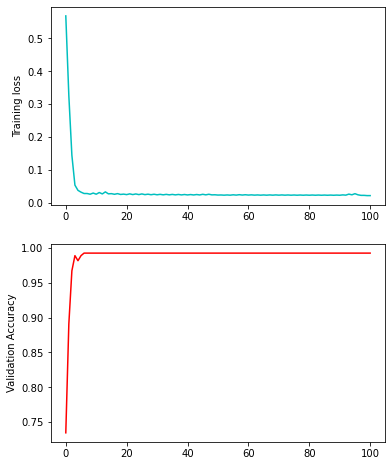

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8))

ax1.plot(list(zip(*train_info))[0],'c')
ax1.set_ylabel("Training loss")
ax2.plot(list(zip(*test_info))[1],'red')
ax2.set_ylabel("Validation Accuracy")